In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Circle
import astropy.units as u
import sunpy.map
from AntennaUtils import *  

# Imprimimos estadísticas resumidas del DataFrame final
pd.set_option('display.float_format', '{:.10f}'.format)

c:\Users\2012m\Desktop\RT-32-SunImage\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# RT32 location (Ventspils, Latvia)
rt32_antenna = RT32()
rt32_antenna.set_location(latitude=57.5535171694, longitude=21.8545525000, elevation=20)

# Define constants
path = ''
year = 2024
month = 2
day = 15
hour_start = 11
minute_start = 25

temperature = u.Quantity(15.5, unit=u.deg_C)
pressure = u.Quantity(1013.25, unit=u.hPa)
relative_humidity = u.Quantity(70.0, unit=u.percent)
obswl =u.Quantity(50000, unit=u.nm) 

weather = Weather(temperature, pressure, relative_humidity, obswl)

observation = SpiralSunObservation(weather,rt32_antenna , year , month , day , hour_start , minute_start)

az_anten, el_anten , az_sun , el_sun , xx1 , yy1, utc = observation.calculatePositions()
observation.generateFile(path, az_anten , el_anten , utc)  

-------------------------------------------------------------
Saved:  sun_scan_240215_1125.ptf    3300   points


True

In [3]:
# Create DataFrame
sunPositionDf = pd.DataFrame({'UTC': utc,'SunX': xx1, 'SunY': yy1  })

fit_file_path = "lnsp4_5ch_240215_112029_122509.fit"
hdu_number = 1  # Number of the extension containing the binary table

# Converts the binary table to a Pandas DataFrame
data_df = bintable_to_pandas(fit_file_path, hdu_number)



In [4]:

RCP_11_df = processData(data_df)


Index(['LCP 01 4.07GHZ', 'LCP 04 6.42GHZ', 'LCP 07 8.40GHZ', 'LCP 09 9.80GHZ',
       'LCP 11 11.90GHZ', 'RCP 01 4.07GHZ', 'RCP 04 6.42GHZ', 'RCP 07 8.40GHZ',
       'RCP 09 9.80GHZ', 'RCP 11 11.90GHZ', 'UTC LCP 01', 'UTC LCP 04',
       'UTC LCP 07', 'UTC LCP 09', 'UTC LCP 11', 'UTC RCP 01', 'UTC RCP 04',
       'UTC RCP 07', 'UTC RCP 09', 'UTC RCP 11'],
      dtype='object')


In [5]:
rest_of_df = getFinalProcessedData(observation , sunPositionDf,RCP_11_df)

print(rest_of_df.describe())

Interpolating data...
Filtering data...
Index(['UTC', 'SunX', 'SunY', 'UTC_11_4_11_90GHZ', 'RCP_11_4_11_90GHZ',
       'LCP_11_4_11_90GHZ'],
      dtype='object')
Calibrating data...
Cantre max:  [7652.79310345 7652.79310345]
Sky min:  [7382.37931034 7382.37931034]


c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df['RCP_11_4_11_90GHZ'] = (rest_of_df['RCP_11_4_11_90GHZ'] - min_vect[0]) / (max_vect[0] - min_vect[0])
c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df['LCP_11_4_11_90GHZ'] = (rest_of_df['LCP_11_4_11_90GHZ'] - min_vect[1]) / (max_vect[1] - min_vect[1])


                   UTC            SunX            SunY  UTC_11_4_11_90GHZ  \
count  1207.0000000000 1207.0000000000 1207.0000000000    1207.0000000000   
mean  42729.3109362055    0.0007213949   -0.0024181763   42729.3109362055   
std     944.9188348102   15.5365717029   15.4934940094     944.9188348102   
min   41160.4980000000  -39.3559052657  -39.6719024686   41160.4980000000   
25%   41944.3675000000  -10.2327127747  -10.1677739887   41944.3675000000   
50%   42730.2970000000    0.0255968612    0.0136946630   42730.2970000000   
75%   43514.1685000000   10.1121099083   10.1018836185   43514.1685000000   
max   44298.0500000000   38.1550737587   38.7912949558   44298.0500000000   

       RCP_11_4_11_90GHZ  LCP_11_4_11_90GHZ  
count    1207.0000000000    1207.0000000000  
mean        0.4809321295       0.4809321295  
std         0.4479044024       0.4479044024  
min        -0.1604182606      -0.1604182606  
25%         0.0855011477       0.0855011477  
50%         0.3536087733      

c:\Users\2012m\Desktop\RT-32-SunImage\AntennaUtils.py:457: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rest_of_df["isoT_time"] = rest_of_df.apply(lambda row: seconds_to_time(observation.year, observation.month, observation.day,row["UTC"]), axis=1)


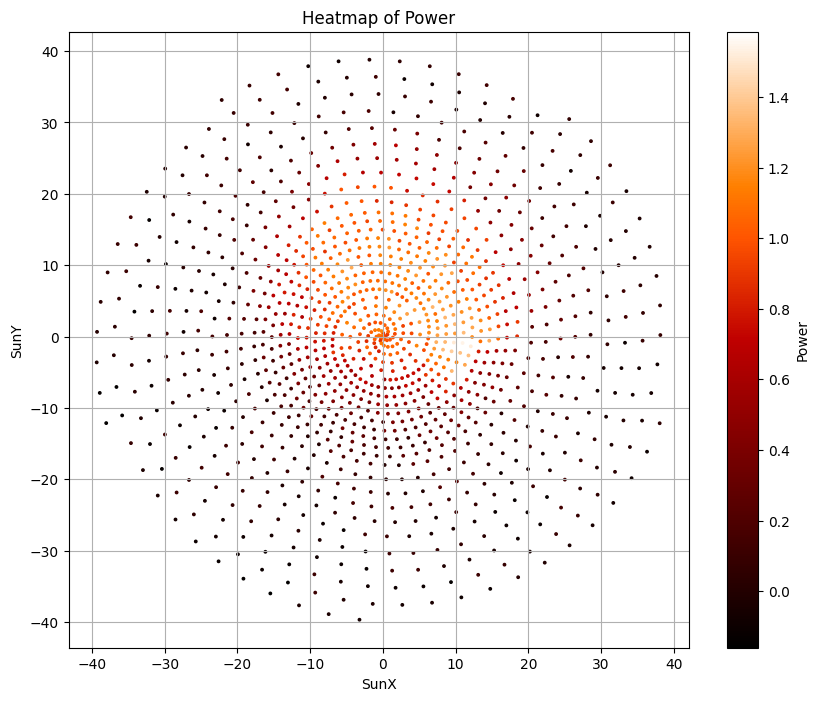

In [7]:
# Create the heatmap
Power = (rest_of_df['RCP_11_4_11_90GHZ'].values +  rest_of_df['LCP_11_4_11_90GHZ'].values) / 2  # Intensidad

plt.figure(figsize=(10, 8))
plt.scatter(rest_of_df['SunX'], rest_of_df['SunY'], c=Power, cmap='gist_heat',s=3)
plt.colorbar(label='Power')
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Heatmap of Power')
plt.grid(True)  # Display the grid for clarity
plt.show()

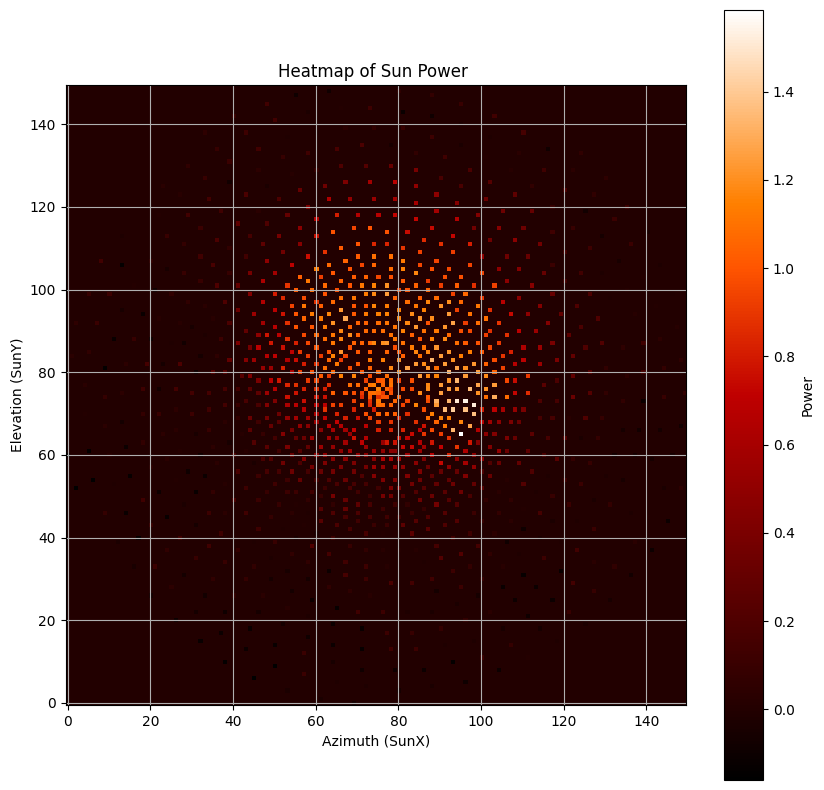

In [8]:
SunX = rest_of_df['SunX']
SunY = rest_of_df['SunY']
Power = (rest_of_df['RCP_11_4_11_90GHZ'].values +  rest_of_df['LCP_11_4_11_90GHZ'].values) / 2  # Intensidad

# Define the size of the grid and create a matrix of zeroes
grid_size = 150
grid_power = np.zeros((grid_size, grid_size))

# Calculate the scale for converting SunX and SunY coordinates to matrix indices
x_min, x_max = SunX.min(), SunX.max()
y_min, y_max = SunY.min(), SunY.max()
x_range = x_max - x_min
y_range = y_max - y_min

# Convert SunX and SunY coordinates to matrix indices
grid_x_index = ((SunX - x_min) / x_range * (grid_size - 1)).astype(int)
grid_y_index = ((SunY - y_min) / y_range * (grid_size - 1)).astype(int)

# Assign Power values to the matrix in the corresponding positions
grid_power[grid_y_index, grid_x_index] = Power

# Show the image
plt.figure(figsize=(10, 10))
plt.imshow(grid_power, cmap='gist_heat', origin='lower')
plt.colorbar(label='Power')
plt.xlabel('Azimuth (SunX)')
plt.ylabel('Elevation (SunY)')
plt.title('Heatmap of Sun Power ')
plt.grid(True)  # Display the grid for clarity
plt.show()


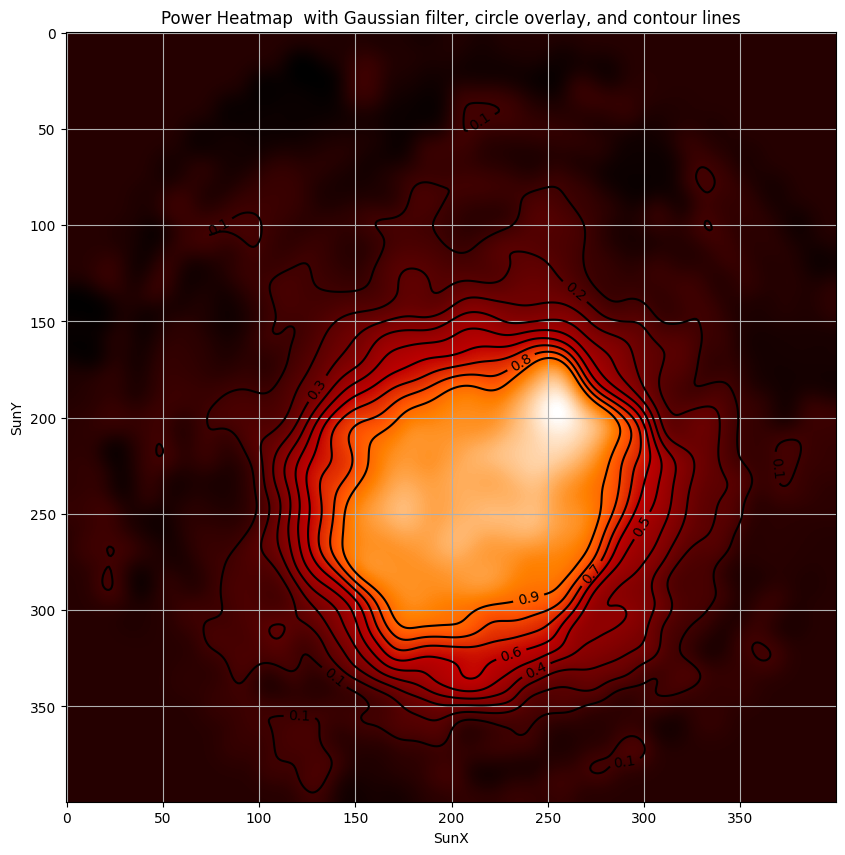

In [9]:
SunX = rest_of_df['SunX']
SunY = rest_of_df['SunY']
Power = (rest_of_df['RCP_11_4_11_90GHZ'].values +  rest_of_df['LCP_11_4_11_90GHZ'].values) / 2  # Intensidad

# Define grid size and point radius
grid_size = 400
point_radius = 10

# Calculate scale to convert SunX and SunY coordinates to matrix indices
x_min, x_max = SunX.min(), SunX.max()
y_min, y_max = SunY.min(), SunY.max()
x_range = x_max - x_min
y_range = y_max - y_min

# Create matrices for power and counts of points in each cell
Z = np.zeros((grid_size, grid_size))
counts = np.zeros((grid_size, grid_size))

# Iterate over each point and expand its power value in matrix Z
for x, y, power in zip(SunX, SunY, Power):
    i = int((x - x_min) / x_range * (grid_size - 1))
    j = int((y - y_min) / y_range * (grid_size - 1))
    
    y_indices, x_indices = np.ogrid[-j:grid_size-j, -i:grid_size-i]
    distances = np.sqrt(x_indices**2 + y_indices**2)
    
    indices_within_radius = np.where(distances <= point_radius)
    
    Z[indices_within_radius] += power
    counts[indices_within_radius] += 1

Z[counts > 0] /= counts[counts > 0]

# Apply Gaussian filter to matrix Z
Z_smoothed = gaussian_filter(Z, sigma=5)


# Create figure and axes
plt.figure(figsize=(10, 10))

# Plot smoothed heatmap
plt.imshow(Z_smoothed, cmap='gist_heat')


# Add contour lines at values rounded to 0.1, 0.2, ..., 0.9
levels = np.arange(0.1, 1.0, 0.1)
contours = plt.contour(Z_smoothed, levels=levels, colors='black')

# Label the contours
plt.clabel(contours, inline=True, fmt='%.1f', fontsize=10)

# Adjust labels and title
plt.xlabel('SunX')
plt.ylabel('SunY')
plt.title('Power Heatmap  with Gaussian filter, circle overlay, and contour lines')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [10]:
print(rest_of_df.describe())



                   UTC            SunX            SunY  UTC_11_4_11_90GHZ  \
count  1207.0000000000 1207.0000000000 1207.0000000000    1207.0000000000   
mean  42729.3109362055    0.0007213949   -0.0024181763   42729.3109362055   
std     944.9188348102   15.5365717029   15.4934940094     944.9188348102   
min   41160.4980000000  -39.3559052657  -39.6719024686   41160.4980000000   
25%   41944.3675000000  -10.2327127747  -10.1677739887   41944.3675000000   
50%   42730.2970000000    0.0255968612    0.0136946630   42730.2970000000   
75%   43514.1685000000   10.1121099083   10.1018836185   43514.1685000000   
max   44298.0500000000   38.1550737587   38.7912949558   44298.0500000000   

       RCP_11_4_11_90GHZ  LCP_11_4_11_90GHZ  
count    1207.0000000000    1207.0000000000  
mean        0.4809321295       0.4809321295  
std         0.4479044024       0.4479044024  
min        -0.1604182606      -0.1604182606  
25%         0.0855011477       0.0855011477  
50%         0.3536087733      

In [11]:
import pandas as pd
import astropy.units as u
from astropy.coordinates import AltAz, SkyCoord
from astropy.time import Time
from sunpy.coordinates import frames, sun

coordsXHelio = []
coordsYHelio = []

# Convert the array of times into a list of Time objects
times = [Time(t) for t in rest_of_df['isoT_time']]

# Calculate the sun's positions for each time in the list
az_sun = observation.sun_location.transform_to(AltAz(obstime=times, location=observation.antenna.location)).az.deg
el_sun = observation.sun_location.transform_to(AltAz(obstime=times, location=observation.antenna.location)).alt.deg

az_anten = az_sun + rest_of_df['SunX'] / np.cos(np.deg2rad(el_sun)) / 60.
el_anten = el_sun + rest_of_df['SunY'] / 60.    


rest_of_df['az_anten'] = az_anten
rest_of_df['el_anten'] = el_anten

# Iterar sobre los diferentes momentos de tiempo
for index, row in rest_of_df.iterrows():
    # Convert the AltAz coordinates from the DataFrame from degrees to radians
    el_deg = row['el_anten'] * u.deg
    az_deg = row['az_anten'] * u.deg

    # Set the observation time
    obstime = row['isoT_time']

    # Convertir a coordenadas heliocéntricas
    frame_altaz = AltAz(obstime=Time(obstime), location=observation.antenna.location)
    sun_helio = SkyCoord(alt=el_deg, az=az_deg, observer='earth' , distance=sun.earth_distance(obstime), frame=frame_altaz).transform_to(frames.Helioprojective)

    
    # Append the transformed coordinates to the list
    coordsXHelio.append(sun_helio.Tx.value)
    coordsYHelio.append(sun_helio.Ty.value)

rest_of_df['tx_helio_anten'] = coordsXHelio
rest_of_df['ty_helio_anten'] = coordsYHelio



In [12]:
print(rest_of_df.describe())



                   UTC            SunX            SunY  UTC_11_4_11_90GHZ  \
count  1207.0000000000 1207.0000000000 1207.0000000000    1207.0000000000   
mean  42729.3109362055    0.0007213949   -0.0024181763   42729.3109362055   
std     944.9188348102   15.5365717029   15.4934940094     944.9188348102   
min   41160.4980000000  -39.3559052657  -39.6719024686   41160.4980000000   
25%   41944.3675000000  -10.2327127747  -10.1677739887   41944.3675000000   
50%   42730.2970000000    0.0255968612    0.0136946630   42730.2970000000   
75%   43514.1685000000   10.1121099083   10.1018836185   43514.1685000000   
max   44298.0500000000   38.1550737587   38.7912949558   44298.0500000000   

       RCP_11_4_11_90GHZ  LCP_11_4_11_90GHZ        az_anten        el_anten  \
count    1207.0000000000    1207.0000000000 1207.0000000000 1207.0000000000   
mean        0.4809321295       0.4809321295  196.8132832178   18.3335488928   
std         0.4479044024       0.4479044024    3.9946673615    0.6522

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


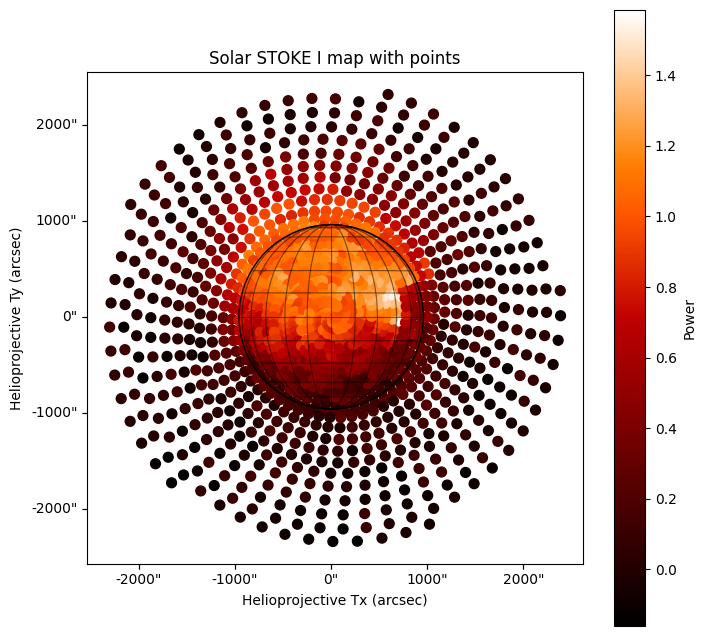

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map

# Supongamos que tienes un DataFrame llamado rest_of_df y tienes dos arrays de objetos coordsXHelio y coordsYHelio
# Definir las coordenadas x e y para los puntos (SunX y SunY)
SunX = rest_of_df['tx_helio_anten']
SunY = rest_of_df['ty_helio_anten']
Power = (rest_of_df['RCP_11_4_11_90GHZ'].values +  rest_of_df['LCP_11_4_11_90GHZ'].values) / 2  # Intensidad


# Definir metadatos para el mapa solar
metadata = {
    'date-obs': '2024-04-30T16:00:00',  # Ajusta esto a la fecha de observación correcta
    'crval1': 0,  
    'crval2': 0,  
    'cdelt1': 1,  
    'cdelt2': 1,  
    'cunit1': 'arcsec',  
    'cunit2': 'arcsec',  
    'ctype1': 'HPLN-TAN',  
    'ctype2': 'HPLT-TAN',  
    'crpix1': 0,  # No necesitamos esto si no estamos usando una matriz predefinida
    'crpix2': 0,  # No necesitamos esto si no estamos usando una matriz predefinida
    'waveunit': 'm',  
    'wavelnth': 0.0262897 * u.m,  
    'obsrvtry': 'Ventspils International Radio Astronomy Center',  
    'detector': 'LNSP4',  
    'dsun_obs': 1 * u.AU,  
    'hglt_obs': 0 * u.deg,  
    'hgln_obs': 0 * u.deg,  
}

# Crear un mapa solar en blanco con los metadatos
blank_map = sunpy.map.Map((np.zeros((10, 10)), metadata))

# Crear el gráfico
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection=blank_map)
blank_map.plot(axes=ax)
blank_map.draw_limb(axes=ax, color="k")
blank_map.draw_grid(axes=ax, color="k")

# Plotear los puntos en el mapa
scatter = ax.scatter(SunX, SunY, c=Power, cmap='gist_heat', s=50)

plt.colorbar(scatter,label='Power' , ax=ax) # Agregar barra de color para la intensidad
plt.title('Solar STOKE I map with points')
plt.xlabel('Helioprojective Tx (arcsec)')
plt.ylabel('Helioprojective Ty (arcsec)')
plt.grid(True)
plt.show()


In [16]:
from scipy.interpolate import Rbf

SunX = rest_of_df['tx_helio_anten']
SunY = rest_of_df['ty_helio_anten']
PowerRCP = rest_of_df['RCP_11_4_11_90GHZ'] 
PowerLCP = rest_of_df['LCP_11_4_11_90GHZ'] 

# Define the grid covering the helioprojective coordinate space
tx_min, tx_max = -1200, 1200
ty_min, ty_max = -1200, 1200
grid_step = 10  # Adjust as needed

# Create a grid
tx, ty = np.meshgrid(np.arange(tx_min, tx_max, grid_step),
                     np.arange(ty_min, ty_max, grid_step))

# Interpolate power values for each point on the grid using Rbf
rbf = Rbf(SunX, SunY, PowerRCP, function='linear')
interp_power_RCP = rbf(tx, ty)

# Create a grid
tx, ty = np.meshgrid(np.arange(tx_min, tx_max, grid_step),
                     np.arange(ty_min, ty_max, grid_step))

# Interpolate power values for each point on the grid using Rbf
rbf = Rbf(SunX, SunY, PowerLCP, function='linear')
interp_power_LCP = rbf(tx, ty)

interp_power_I = (interp_power_RCP + interp_power_LCP) / 2
interp_power_V =  (interp_power_RCP - interp_power_LCP) / 2


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


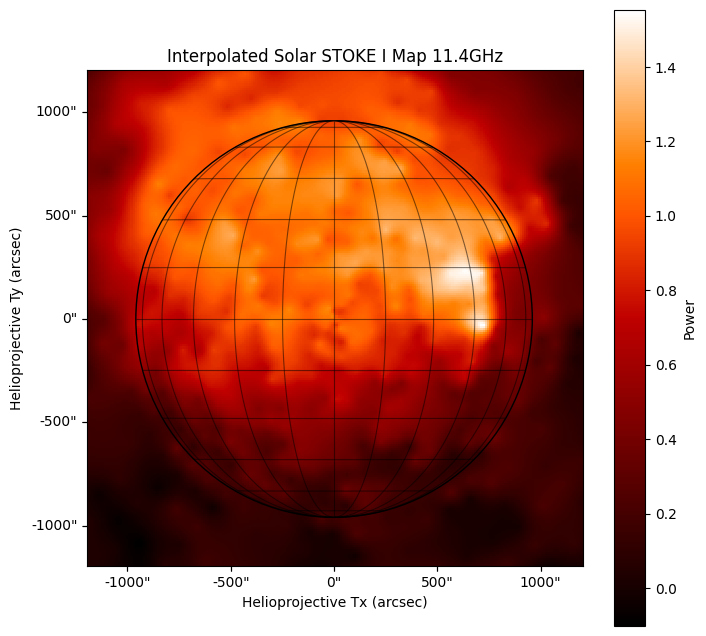

In [17]:

# Define metadata for the solar map
metadata = {
    'date-obs': '2024-04-30T16:00:00',  # Adjust this to the correct observation date
    'crval1': 0,
    'crval2': 0,
    'cdelt1': grid_step,
    'cdelt2': grid_step,
    'cunit1': 'arcsec',
    'cunit2': 'arcsec',
    'ctype1': 'HPLN-TAN',
    'ctype2': 'HPLT-TAN',
    'crpix1': (tx_max - tx_min) / (2 * grid_step),
    'crpix2': (ty_max - ty_min) / (2 * grid_step),
    'waveunit': 'm',
    'wavelnth': 0.0262897 * u.m,
    'obsrvtry': 'Ventspils International Radio Astronomy Center',
    'detector': 'LNSP4',
    'dsun_obs': 1 * u.AU,
    'hglt_obs': 0 * u.deg,
    'hgln_obs': 0 * u.deg,
}

# Create a map using the interpolated power values and metadata
interpolated_map = sunpy.map.Map((interp_power_I, metadata))

# Plot the interpolated map using a heatmap with the 'hot' colormap
plt.figure(figsize=(8, 8))
interpolated_map.plot(cmap='gist_heat')
interpolated_map.draw_limb(color="k")
interpolated_map.draw_grid(color="k")
plt.colorbar(label='Power')
plt.title('Interpolated Solar STOKE I Map 11.4GHz')
plt.xlabel('Helioprojective Tx (arcsec)')
plt.ylabel('Helioprojective Ty (arcsec)')
plt.grid(True)
plt.show()


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


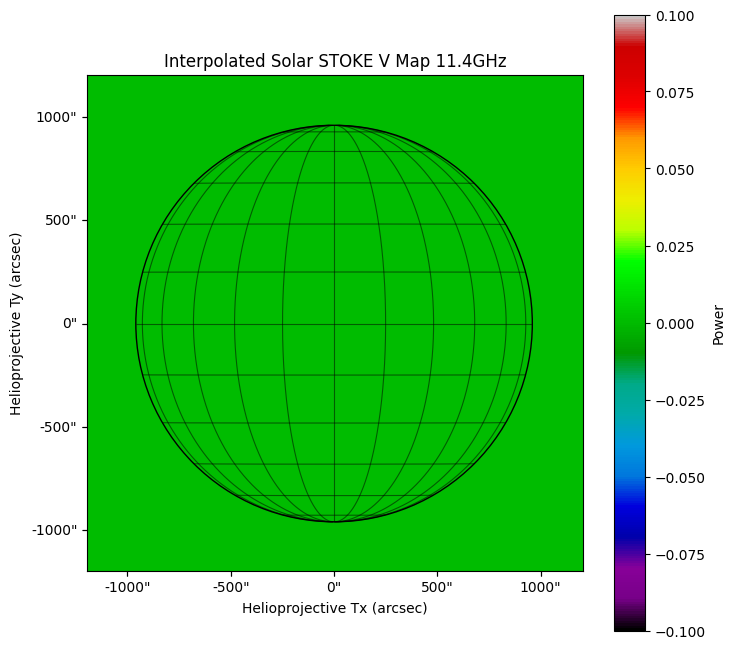

In [18]:

# Define metadata for the solar map
metadata = {
    'date-obs': '2024-04-30T16:00:00',  # Adjust this to the correct observation date
    'crval1': 0,
    'crval2': 0,
    'cdelt1': grid_step,
    'cdelt2': grid_step,
    'cunit1': 'arcsec',
    'cunit2': 'arcsec',
    'ctype1': 'HPLN-TAN',
    'ctype2': 'HPLT-TAN',
    'crpix1': (tx_max - tx_min) / (2 * grid_step),
    'crpix2': (ty_max - ty_min) / (2 * grid_step),
    'waveunit': 'm',
    'wavelnth': 0.0262897 * u.m,
    'obsrvtry': 'Ventspils International Radio Astronomy Center',
    'detector': 'LNSP4',
    'dsun_obs': 1 * u.AU,
    'hglt_obs': 0 * u.deg,
    'hgln_obs': 0 * u.deg,
}

# Create a map using the interpolated power values and metadata
interpolated_map = sunpy.map.Map((interp_power_V, metadata))

# Plot the interpolated map using a heatmap with the 'hot' colormap
plt.figure(figsize=(8, 8))
interpolated_map.plot(cmap='nipy_spectral')
interpolated_map.draw_limb(color="k")
interpolated_map.draw_grid(color="k")
plt.colorbar(label='Power')
plt.title('Interpolated Solar STOKE V Map 11.4GHz')
plt.xlabel('Helioprojective Tx (arcsec)')
plt.ylabel('Helioprojective Ty (arcsec)')
plt.grid(True)
plt.show()
